In [1]:
import pandas as pd
import chess
import numpy as np
import sklearn

In [135]:
df = pd.read_csv('games.csv')
df.drop_duplicates(subset='id', inplace=True)
df = df.loc[df['victory_status'] == 'mate']
df.head()

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
2,mIICvQHh,True,1.504130e+12,1.504130e+12,61,mate,white,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,King's Pawn Game: Leonardis Variation,3
3,kWKvrqYL,True,1.504110e+12,1.504110e+12,61,mate,white,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,Queen's Pawn Game: Zukertort Variation,3
4,9tXo1AUZ,True,1.504030e+12,1.504030e+12,95,mate,white,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,Philidor Defense,5
9,afoMwnLg,True,1.503440e+12,1.503440e+12,119,mate,white,10+0,daniel_likes_chess,1381,mirco25,1209,e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6 d4 Qf5 Bxa6 b...,B01,Scandinavian Defense: Mieses-Kotroc Variation,4
10,HgKLWPsz,False,1.503350e+12,1.503350e+12,39,mate,white,20+60,daniel_likes_chess,1381,anaissac,1272,e3 e6 d4 d6 Bd3 c6 Nf3 Be7 Nc3 Nf6 Bd2 Bd7 Qe2...,A00,Van't Kruijs Opening,1


In [136]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5974 entries, 2 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5974 non-null   object 
 1   rated           5974 non-null   bool   
 2   created_at      5974 non-null   float64
 3   last_move_at    5974 non-null   float64
 4   turns           5974 non-null   int64  
 5   victory_status  5974 non-null   object 
 6   winner          5974 non-null   object 
 7   increment_code  5974 non-null   object 
 8   white_id        5974 non-null   object 
 9   white_rating    5974 non-null   int64  
 10  black_id        5974 non-null   object 
 11  black_rating    5974 non-null   int64  
 12  moves           5974 non-null   object 
 13  opening_eco     5974 non-null   object 
 14  opening_name    5974 non-null   object 
 15  opening_ply     5974 non-null   int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 752.6+ KB


In [138]:
def get_turns_df(game_id):

    board = chess.Board()

    game = df.loc[df['id'] == game_id]
    moves = game['moves'].item().split(' ')

    game_state = dict()
    game_state['turn_nbr'] = [0]
    game_state[('black', 'pawn')] = [8]
    game_state[('black', 'bishop')] = [2]
    game_state[('black', 'knight')] = [2]
    game_state[('black', 'rook')] = [2]
    game_state[('black', 'queen')] = [1]
    game_state[('white', 'pawn')] = [8]
    game_state[('white', 'bishop')] = [2]
    game_state[('white', 'knight')] = [2]
    game_state[('white', 'rook')] = [2]
    game_state[('white', 'queen')] = [1]


    for i, move in enumerate(moves):

        # duplicate previous game state, increment turn_nbr
        for k, v in game_state.items():
            if k=='turn_nbr':
                game_state['turn_nbr'].append(i+1)
            else:
                prev = game_state[k][-1]
                game_state[k].append(prev)

        # decrement (color, piece) if attack occurs
        if 'x' in move:
            attack_to_square_str = move.split('x')[1].replace('+', '').replace('#', '').split('=')[0]
            attack_to_square = chess.parse_square(attack_to_square_str)

            try:
                attacked_piece = chess.piece_name(board.piece_type_at(attack_to_square))
            except:
                # en passant, pawn captures pawn + lands on a square with no prior occupant
                attacked_piece = 'pawn'
            attacked_color = board.color_at(attack_to_square)
            if attacked_color == chess.WHITE:
                game_state[('white', attacked_piece)][-1] -= 1
            else:
                game_state[('black', attacked_piece)][-1] -= 1

        # upgrade pawn to new piece
        if '=' in move:
            
            if board.turn == chess.WHITE:
                player = 'white'
            else:
                player = 'black'

            
            piece = chess.Piece.from_symbol(move.replace('+', '').replace('#', '').split('=')[1])
            new_piece = chess.piece_name(piece.piece_type)

            # decrement pawn, increment new piece
            game_state[(player, 'pawn')][-1] -=1
            game_state[(player, new_piece)][-1] +=1


        # move piece
        board.push_san(move)

    turns_df = pd.DataFrame.from_dict(game_state)
    
    turns_df['game_id'] = pd.Series([game.id.item()] * len(turns_df))
    turns_df['winner'] = pd.Series([game.winner.item()] * len(turns_df))

    return turns_df


In [139]:
turns_df_list = []
i = 0
for game_id in df['id']:
    try:
        tmp_df = get_turns_df(game_id)
    except:
        print(game_id)
        print(i)
        break
    turns_df_list.append(tmp_df)
    i += 1
    if i % 1000 == 0:
        print(i)

1000
2000
3000
4000
5000


In [140]:
len(turns_df_list)

5974

In [141]:
df['turns'].sum()

np.int64(391709)

In [142]:
turns_df = pd.concat(turns_df_list, ignore_index=True)

In [143]:
len(turns_df)

397683

In [144]:
len(turns_df) - df['turns'].sum()

np.int64(5974)

In [145]:
turns_df.head(5)

,turn_nbr,"(black, pawn)","(black, bishop)","(black, knight)","(black, rook)","(black, queen)","(white, pawn)","(white, bishop)","(white, knight)","(white, rook)","(white, queen)",game_id,winner
0,0,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white
1,1,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white
2,2,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white
3,3,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white
4,4,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white


In [146]:
import numpy as np

turns_df = turns_df.assign(
    net_pawns = lambda d: d[('white', 'pawn')] - d[('black', 'pawn')],
    net_bishops = lambda d: d[('white', 'bishop')] - d[('black', 'bishop')],
    net_knights = lambda d: d[('white', 'knight')] - d[('black', 'knight')],
    net_rooks = lambda d: d[('white', 'rook')] - d[('black', 'rook')],
    net_queens = lambda d: d[('white', 'queen')] - d[('black', 'queen')],
    winner_bool = lambda d: np.where(d['winner']=='white', 1, 0)
)
turns_df

,turn_nbr,"(black, pawn)","(black, bishop)","(black, knight)","(black, rook)","(black, queen)","(white, pawn)","(white, bishop)","(white, knight)","(white, rook)","(white, queen)",game_id,winner,net_pawns,net_bishops,net_knights,net_rooks,net_queens,winner_bool
0,0,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white,0,0,0,0,0,1
1,1,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white,0,0,0,0,0,1
2,2,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white,0,0,0,0,0,1
3,3,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white,0,0,0,0,0,1
4,4,8,2,2,2,1,8,2,2,2,1,mIICvQHh,white,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
397678,74,3,0,0,1,1,4,0,0,0,1,N8G2JHGG,black,1,0,0,-1,0,0
397679,75,3,0,0,1,1,4,0,0,0,1,N8G2JHGG,black,1,0,0,-1,0,0
397680,76,3,0,0,1,1,4,0,0,0,1,N8G2JHGG,black,1,0,0,-1,0,0
397681,77,3,0,0,1,1,4,0,0,0,1,N8G2JHGG,black,1,0,0,-1,0,0


# turn-agnostic

## logistic regression

In [134]:
X = turns_df[['net_pawns', 'net_bishops', 'net_knights', 'net_rooks', 'net_queens']]
y = turns_df['winner_bool']

In [147]:
from sklearn.linear_model import LogisticRegression

m = LogisticRegression()
m.fit(X, y)

LogisticRegression()

In [149]:
m.coef_

array([[0.40127924, 0.938732  , 0.8321865 , 1.28368995, 2.39317343]])

In [150]:
# with each additional net piece, your odds to win are x times higher
np.exp(m.coef_)

array([[ 1.49373432,  2.55673743,  2.29833857,  3.60993568, 10.94818216]])

## sigmoid NN

In [152]:
from sklearn.neural_network import MLPClassifier

m = MLPClassifier(hidden_layer_sizes=(), alpha = 0, max_iter=10000, activation='logistic')
m


MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=(),
              max_iter=10000)

In [153]:
m.fit(X, y)

MLPClassifier(activation='logistic', alpha=0, hidden_layer_sizes=(),
              max_iter=10000)

In [155]:
# oh wait this is the same LOL duh
m.coefs_

[array([[0.41976504],
        [0.94248887],
        [0.83638778],
        [1.30840777],
        [2.38475132]])]

In [180]:
pawn_value = m.coefs_[0][0][0]
nested_list = (m.coefs_ / pawn_value)[0].tolist()

piece_values = sorted(zip(
    [round(x, 2) for sublist in nested_list for x in sublist], 
    ['pawn', 'bishop', 'knight', 'rook', 'queen']
    ), key = lambda x: x[0]
)

In [181]:
piece_values

[(1.0, 'pawn'),
 (1.99, 'knight'),
 (2.25, 'bishop'),
 (3.12, 'rook'),
 (5.68, 'queen')]

In [185]:
import seaborn as sns

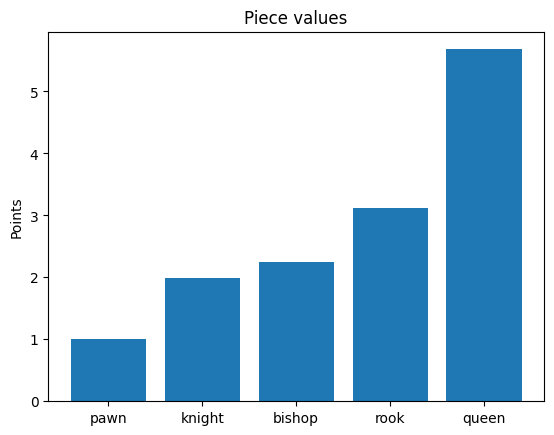

In [192]:
import matplotlib.pyplot as plt

plt.bar(
    x=[x[1] for x in piece_values],
    height=[x[0] for x in piece_values]
)
plt.ylabel('Points')
plt.title('Piece values')
plt.savefig('img/results.png')
    